# APS SYSTEM FAILURE PREDICTION IN SCANIA TRUCKS

The data set consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes. The data sets' positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The data consists of a subset of all available data, selected by experts. The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record. It was imported from the UCI ML Repository https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_training_set.csv
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_test_set.csv

--2019-02-05 09:28:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_training_set.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44669194 (43M) [text/csv]
Saving to: ‘aps_failure_training_set.csv.6’

100%[======================================>] 44,669,194  32.0MB/s   in 1.3s   

2019-02-05 09:28:25 (32.0 MB/s) - ‘aps_failure_training_set.csv.6’ saved [44669194/44669194]

--2019-02-05 09:28:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_test_set.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11943558 (11M) [text/csv]
Saving to: ‘aps_failure_test_set.csv.7’

100%[====================

# Machine Learning Model with Spark ML
## Logistic Regression Classifier

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import pyspark.sql.functions as f
from pyspark.sql.functions import col

# Load Data Set to pandas
train = pd.read_csv("aps_failure_training_set.csv", skiprows=20)
test = pd.read_csv("aps_failure_test_set.csv", skiprows=20)

# Create Spark data frame from panda data frame
spark_df = sqlContext.createDataFrame(train)
spark_test_df = sqlContext.createDataFrame(test)

# Create function class attribute processing
def index_processor(df):
    indexer = StringIndexer(inputCol="class", outputCol="label")
    indexed = indexer.fit(df).transform(df)
    return indexed

# Create function for vector assembler processing of features
def vector_assembler_processor(indexed):
    indexed_1 = indexed
    vector_features = indexed_1.drop('class', 'label').columns
    vectorAssembler = VectorAssembler(inputCols= vector_features, outputCol="features")
    expr = [col(c).cast("Double").alias(c)
            for c in vectorAssembler.getInputCols()]
    indexed_1 = indexed_1.select(*expr)
    indexed_1 = indexed_1.fillna(0)
    features_vectorized = vectorAssembler.transform(indexed_1)
    return features_vectorized  


# Make final data frame to train the model
def make_df_train(features_vectorized, indexed):
    df_train = features_vectorized.select("features")
    label = indexed.select("label")
    df_train = df_train.withColumn('row_index', f.monotonically_increasing_id())
    label=label.withColumn('row_index', f.monotonically_increasing_id())
    df_train = df_train.join(label, on=["row_index"]).sort("row_index").drop("row_index")
    return df_train

# Compile all above function to one function for easy processing of data set
def processor(df):
    indexed = index_processor(df)
    features_vectorized = vector_assembler_processor(indexed)
    df_processed = make_df_train(features_vectorized, indexed)
    return df_processed

# Pre process training data frame
df_train = processor(spark_df)

# Create model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(df_train)

# Traing the model
prediction = model.transform(df_train)
print("Prediction schema")
prediction.printSchema()

# Evaluate the model performance on traing data set
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")
print("Evaluation score on training set.....")    
print(binEval.evaluate(prediction))

Prediction schema
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)

Evaluation score on training set.....
0.9833333333333333


## Prediction on Test Set

In [4]:
# Pre process test data frame
df_test = processor(spark_test_df) 

# Make prediction on the test data frame
test_prediction = model.transform(df_test)
# Evaluate model performance on test data frame
print("Evaluation score on test set.....")
print(binEval.evaluate(test_prediction))

Evaluation score on test set.....
0.9765625


## Model Performance Indicators

In [5]:
# Import required libraries

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer
import scikitplot as skplt
from tqdm import tqdm


In [6]:
# Create numpy arrays of True labels and predicted labels
y_test_norm = np.array(df_test.select("label").collect())
y_pred_norm = np.array(test_prediction.select("label").collect())

classification report...
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     15625
        1.0       1.00      1.00      1.00       375

avg / total       1.00      1.00      1.00     16000

Confusion matrix plot...


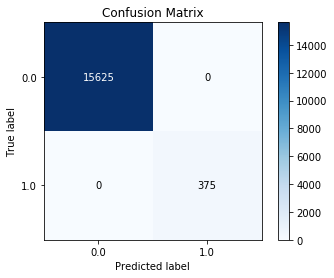

In [7]:
# Create classification report and confusion matrix plot 
print("classification report...")
print(classification_report(y_test_norm, y_pred_norm))
tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
print("Confusion matrix plot...")
skplt.metrics.plot_confusion_matrix(y_test_norm, y_pred_norm, normalize=False)
plt.show()



## Predict Total Cost of Model

In [10]:
print("Total Cost for the model:", (10*fp + 500*fn))

Total Cost for the model: 0


## Save model 

In [11]:
model.save('spark_lr_model_1.h5')